In [3]:
import tensorflow as tf
%load_ext tensorboard
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
import datetime
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statistics
!rm -rf ./logs/ 
print(tf.__version__) #Double check the colab has the instance of tensorflow we want

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.15.1


# Import the Dataset

In [4]:
lab_data = pd.read_csv('../data/83_Loeschcke_et_al_2000_Thorax_&_wing_traits_lab pops.csv')

# Data Cleaning

In [5]:
lab_data = pd.read_csv('../data/83_Loeschcke_et_al_2000_Thorax_&_wing_traits_lab pops.csv')

# Data cleaning
erroneous = lab_data[lab_data['Thorax_length'] == '.']
erroneous

,Species,Population,Latitude,Longitude,Year_start,Year_end,Temperature,Vial,Replicate,Sex,Thorax_length,l2,l3p,l3d,lpd,l3,w1,w2,w3,wing_loading
253,D._aldrichi,Gogango_Creek,-23.77,150.17,1994,1994,25,6,3,female,.,1.65,0.573,1.415,1.988,1.986,0.898,1.207,1.003,.


In [6]:
similar_rows = lab_data[
    (lab_data['Species'] == 'D._aldrichi')
    & (lab_data['Population'] == 'Gogango_Creek')
    & (lab_data['Sex'] == 'female')
    & (lab_data['Thorax_length'] != ".")
]
similar_rows['Thorax_length'] = pd.to_numeric(similar_rows['Thorax_length'])
similar_rows.head()

/var/folders/j_/9f1md2vd0_s6kpn12szf1t2c0000gn/T/ipykernel_23425/3776846164.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_rows['Thorax_length'] = pd.to_numeric(similar_rows['Thorax_length'])


,Species,Population,Latitude,Longitude,Year_start,Year_end,Temperature,Vial,Replicate,Sex,Thorax_length,l2,l3p,l3d,lpd,l3,w1,w2,w3,wing_loading
162,D._aldrichi,Gogango_Creek,-23.77,150.17,1994,1994,20,1,1,female,1.166,1.910,0.578,1.675,2.254,2.252,0.982,1.381,1.123,1.932
164,D._aldrichi,Gogango_Creek,-23.77,150.17,1994,1994,20,1,2,female,1.174,1.829,0.622,1.549,2.170,2.170,0.997,1.360,1.117,1.848
166,D._aldrichi,Gogango_Creek,-23.77,150.17,1994,1994,20,1,3,female,1.199,1.864,0.585,1.659,2.244,2.242,1.009,1.376,1.142,1.870
167,D._aldrichi,Gogango_Creek,-23.77,150.17,1994,1994,20,2,1,female,1.186,1.872,0.628,1.571,2.199,2.199,1.002,1.356,1.143,1.854
169,D._aldrichi,Gogango_Creek,-23.77,150.17,1994,1994,20,2,2,female,1.176,1.872,0.630,1.579,2.207,2.207,0.966,1.345,1.103,1.876


In [7]:
similar_row_median = similar_rows['Thorax_length'].median()

lab_data['Thorax_length'] = lab_data.apply(
    lambda x: (x['Thorax_length'] if x['Thorax_length'] != "." else similar_row_median),
    axis=1
)
lab_data.head()

lab_data['wing_loading'] = lab_data.apply(
    lambda x: (x['wing_loading'] if x['wing_loading'] != "." else round((x['l3'] / x['Thorax_length']), 3)),
    axis=1
)

print(len(similar_rows))
print(similar_row_median)

lab_data.loc[253]

87
1.141


Species            D._aldrichi
Population       Gogango_Creek
Latitude                -23.77
Longitude               150.17
Year_start                1994
Year_end                  1994
Temperature                 25
Vial                         6
Replicate                    3
Sex                     female
Thorax_length            1.141
l2                        1.65
l3p                      0.573
l3d                      1.415
lpd                      1.988
l3                       1.986
w1                       0.898
w2                       1.207
w3                       1.003
wing_loading             1.741
Name: 253, dtype: object

In [8]:
similar_row_median = similar_rows['Thorax_length'].median()

lab_data['Thorax_length'] = lab_data.apply(
    lambda x: (x['Thorax_length'] if x['Thorax_length'] != "." else similar_row_median),
    axis=1
)
lab_data.head()

lab_data['wing_loading'] = lab_data.apply(
    lambda x: (x['wing_loading'] if x['wing_loading'] != "." else round((x['l3'] / x['Thorax_length']), 3)),
    axis=1
)

print(len(similar_rows))
print(similar_row_median)

lab_data.loc[253]

87
1.141


Species            D._aldrichi
Population       Gogango_Creek
Latitude                -23.77
Longitude               150.17
Year_start                1994
Year_end                  1994
Temperature                 25
Vial                         6
Replicate                    3
Sex                     female
Thorax_length            1.141
l2                        1.65
l3p                      0.573
l3d                      1.415
lpd                      1.988
l3                       1.986
w1                       0.898
w2                       1.207
w3                       1.003
wing_loading             1.741
Name: 253, dtype: object

In [9]:
lab_data['Thorax_length'] = pd.to_numeric(lab_data['Thorax_length'])
lab_data['wing_loading'] = pd.to_numeric(lab_data['wing_loading'])

In [10]:
erroneous_2 = lab_data[(lab_data['l3d'] == 0) & (lab_data['l3p'] != 0)]
erroneous_2

,Species,Population,Latitude,Longitude,Year_start,Year_end,Temperature,Vial,Replicate,Sex,Thorax_length,l2,l3p,l3d,lpd,l3,w1,w2,w3,wing_loading
61,D._aldrichi,Binjour,-25.52,151.45,1994,1994,25,3,1,female,1.106,0.0,0.6,0.0,0.0,0.0,0.0,1.252,0.0,0.0


In [11]:
similar_rows_2 = lab_data[
    (lab_data['Species'] == 'D._aldrichi')
    & (lab_data['Population'] == 'Binjour')
    & (lab_data['Sex'] == 'female')
    & (lab_data['l3d'] != "0")
]

similar_rows_2_l2_median = similar_rows_2['l2'].median()
similar_rows_2_l3d_median = similar_rows_2['l3d'].median()
similar_rows_2_lpd_median = similar_rows_2['lpd'].median()
similar_rows_2_l3_median = similar_rows_2['l3'].median()
similar_rows_2_w1_median = similar_rows_2['w1'].median()
similar_rows_2_w3_median = similar_rows_2['w3'].median()
lab_data.loc[61, 'l2'] = similar_rows_2_l2_median
lab_data.loc[61, 'l3d'] = similar_rows_2_l3d_median
lab_data.loc[61, 'lpd'] = similar_rows_2_lpd_median
lab_data.loc[61, 'l3'] = similar_rows_2_l3_median
lab_data.loc[61, 'w1'] = similar_rows_2_w1_median
lab_data.loc[61, 'w3'] = similar_rows_2_w3_median
lab_data.loc[61, 'wing_loading'] = lab_data.loc[61]['l3'] / lab_data.loc[61]['Thorax_length']
lab_data.loc[[61]]

,Species,Population,Latitude,Longitude,Year_start,Year_end,Temperature,Vial,Replicate,Sex,Thorax_length,l2,l3p,l3d,lpd,l3,w1,w2,w3,wing_loading
61,D._aldrichi,Binjour,-25.52,151.45,1994,1994,25,3,1,female,1.106,1.799,0.6,1.5235,2.1195,2.1185,0.9235,1.252,1.0495,1.915461


In [12]:
erroneous_3 = lab_data[(lab_data['l3d'] == 0) & (lab_data['l3p'] == 0)]
erroneous_3

,Species,Population,Latitude,Longitude,Year_start,Year_end,Temperature,Vial,Replicate,Sex,Thorax_length,l2,l3p,l3d,lpd,l3,w1,w2,w3,wing_loading
698,D._aldrichi,Wahruna,-25.2,151.17,1994,1994,20,5,3,female,1.151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#TODO: 
similar_rows_3 = lab_data[
    (lab_data['Species'] == 'D._aldrichi')
    & (lab_data['Population'] == 'Wahruna')
    & (lab_data['Sex'] == 'female')
    & (lab_data['l3d'] != "0")
]
len(similar_rows_3)

84

In [14]:
similar_rows_3_l2_median = similar_rows_3['l2'].median()
similar_rows_3_l3p_median = similar_rows_3['l3p'].median()
similar_rows_3_l3d_median = similar_rows_3['l3d'].median()
similar_rows_3_lpd_median = similar_rows_3['lpd'].median()
similar_rows_3_l3_median = similar_rows_3['l3'].median()
similar_rows_3_w1_median = similar_rows_3['w1'].median()
similar_rows_3_w2_median = similar_rows_3['w2'].median()
similar_rows_3_w3_median = similar_rows_3['w3'].median()


lab_data.loc[698, 'l2'] = similar_rows_3_l2_median
lab_data.loc[698, 'l3p'] = similar_rows_3_l3p_median
lab_data.loc[698, 'l3d'] = similar_rows_3_l3d_median
lab_data.loc[698, 'lpd'] = similar_rows_3_lpd_median
lab_data.loc[698, 'l3'] = similar_rows_3_l3_median
lab_data.loc[698, 'w1'] = similar_rows_3_w1_median
lab_data.loc[698, 'w2'] = similar_rows_3_w2_median
lab_data.loc[698, 'w3'] = similar_rows_3_w3_median
lab_data.loc[698, 'wing_loading'] = lab_data.loc[698]['l3'] / lab_data.loc[698]['Thorax_length']

lab_data.loc[[698]]

,Species,Population,Latitude,Longitude,Year_start,Year_end,Temperature,Vial,Replicate,Sex,Thorax_length,l2,l3p,l3d,lpd,l3,w1,w2,w3,wing_loading
698,D._aldrichi,Wahruna,-25.2,151.17,1994,1994,20,5,3,female,1.151,1.7405,0.6,1.4925,2.0855,2.084,0.943,1.2805,1.0645,1.810599


# Model Building

In [15]:
lab_data['Thorax_length'] = pd.to_numeric(lab_data['Thorax_length'])
lab_data['wing_loading'] = pd.to_numeric(lab_data['wing_loading'])

In [16]:
lab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1731 entries, 0 to 1730
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Species        1731 non-null   object 
 1   Population     1731 non-null   object 
 2   Latitude       1731 non-null   float64
 3   Longitude      1731 non-null   float64
 4   Year_start     1731 non-null   int64  
 5   Year_end       1731 non-null   int64  
 6   Temperature    1731 non-null   int64  
 7   Vial           1731 non-null   int64  
 8   Replicate      1731 non-null   int64  
 9   Sex            1731 non-null   object 
 10  Thorax_length  1731 non-null   float64
 11  l2             1731 non-null   float64
 12  l3p            1731 non-null   float64
 13  l3d            1731 non-null   float64
 14  lpd            1731 non-null   float64
 15  l3             1731 non-null   float64
 16  w1             1731 non-null   float64
 17  w2             1731 non-null   float64
 18  w3      

In [17]:
lab_data = shuffle(lab_data)
lab_data['class'] = lab_data.apply(
    lambda x: f"{x['Species']}, {x['Population']}, {x['Sex']}",
    axis=1
)

# encode class labels to integers
lab_data['class'] = lab_data['class'].astype('category').cat.codes

train, test = train_test_split(lab_data, test_size=0.2)

lab_data.head()

,Species,Population,Latitude,Longitude,Year_start,Year_end,Temperature,Vial,Replicate,Sex,...,l2,l3p,l3d,lpd,l3,w1,w2,w3,wing_loading,class
1286,D._buzzatii,Grandchester,-27.68,152.45,1994,1994,25,6,1,female,...,1.814,0.603,1.536,2.138,2.138,0.954,1.325,1.083,1.868,14
524,D._aldrichi,Oxford_Downs,-21.77,148.85,1994,1994,20,3,2,male,...,1.750,0.591,1.475,2.066,2.064,0.997,1.332,1.106,1.831,7
1647,D._buzzatii,Wahruna,-25.20,151.17,1994,1994,25,6,3,female,...,1.898,0.647,1.551,2.199,2.198,0.970,1.354,1.100,1.852,18
264,D._aldrichi,Gogango_Creek,-23.77,150.17,1994,1994,25,8,2,male,...,1.601,0.546,1.390,1.936,1.936,0.894,1.193,0.992,1.813,3
1641,D._buzzatii,Wahruna,-25.20,151.17,1994,1994,25,5,3,female,...,1.870,0.665,1.516,2.181,2.181,0.962,1.332,1.099,1.774,18


### Create tensor batches

In [18]:

#cifar_x_train = cifar_x_train.astype(np.float32)
#cifar_x_test = cifar_x_test.astype(np.float32)

train_ds = tf.data.Dataset.from_tensor_slices(
    (
    train[['Thorax_length', 'l2', 'l3p', 'l2', 'l3p', 'l2', 'l3p', 'l2', 'l3p', 'l2', 'l3p', 'wing_loading']],
    train[['class']]
    )
).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices(
    (
    test[['Thorax_length', 'l2', 'l3p', 'l2', 'l3p', 'l2', 'l3p', 'l2', 'l3p', 'l2', 'l3p', 'wing_loading']],
    test[['class']]
    )
).batch(32)


In [25]:
class ModelTester:
    def __init__(
        self,
        model_name,
        model, 
        optimiser = None,
        loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    ):
        self._model = model
        self.model_name = model_name
        if optimiser is None:
            self._optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5) 
        self._loss_object = loss_object
        self._train_loss = tf.keras.metrics.Mean(name='train_loss')
        self._train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    
        self._test_loss = tf.keras.metrics.Mean(name='test_loss')
        self._test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
    
        self._training_results = []
        self._training_set_accuracy = []
        self._test_set_accuracy = []
        self._mean_training_accuracy = []
        self._mean_test_accuracy = []
  
    @tf.function
    def train_step(self, images, labels):
        with tf.GradientTape() as tape:
            # training=true is only needed if there are layers with different
            # behavior during training versus inference (e.g. dropout).
            predictions = self._model(images, training=True)
            loss = self._loss_object(labels, predictions)
        gradients = tape.gradient(loss, self._model.trainable_variables)
        self._optimiser.apply_gradients(zip(gradients, self._model.trainable_variables))
        
        self._train_loss(loss)
        self._train_accuracy(labels, predictions) 
    
    @tf.function
    def test_step(self, images, labels):
        # training=False is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = self._model(images, training=False)
        t_loss = self._loss_object(labels, predictions)
        
        self._test_loss(t_loss)
        self._test_accuracy(labels, predictions)
    
    def train(self, train_ds, test_ds, epochs):
        for epoch in range(epochs):
            # Reset the metrics at the start of the next epoch
            self._train_loss.reset_state()
            self._train_accuracy.reset_state()
            self._test_loss.reset_state()
            self._test_accuracy.reset_state()
            
            for images, labels in train_ds:
                self.train_step(images, labels)
            
            for test_images, test_labels in test_ds:
                self.test_step(test_images, test_labels)

            self._training_set_accuracy.append(float(self._train_accuracy.result()))
            self._test_set_accuracy.append(float(self._test_accuracy.result()))
            '''
            template = 'Model: {}, Epoch: {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
            print(template.format(
                self.model_name,
                epoch + 1,
                self._train_loss.result(),
                self._train_accuracy.result() * 100,
                self._test_loss.result(),
                self._test_accuracy.result() * 100)
            )
            '''

            if len(self._training_set_accuracy) < 10:
                mean_training_accuracy = statistics.fmean(self._training_set_accuracy)
            else:
                mean_training_accuracy = statistics.fmean(self._training_set_accuracy[-10:])

            if len(self._test_set_accuracy) < 10:
                mean_test_set_accuracy = statistics.fmean(self._test_set_accuracy)
            else:
                mean_test_set_accuracy = statistics.fmean(self._test_set_accuracy[-10:])
            
            self._training_results.append({
                'epoch': epoch + 1,
                'training_set_loss': float(self._train_loss.result()),
                'mean_training_set_accuracy': mean_training_accuracy,
                'training_set_accuracy': float(self._train_accuracy.result()),
                'test_set_loss': float(self._test_loss.result()),
                'mean_test_set_accuracy': mean_test_set_accuracy,
                'test_set_accuracy': float(self._test_accuracy.result()) 
            })
            
            if epoch % 500 == 0:
                print(f'Epoch: {epoch + 1}')

        #print(self._training_results)
        training_results_df = pd.DataFrame(self._training_results)
        #print(training_results_df.head())
        training_results_df.plot(kind='line', x='epoch', y='mean_training_set_accuracy')
        plt.show()
        training_results_df.plot(kind='line', x='epoch', y='training_set_accuracy')
        plt.show()
        training_results_df.plot(kind='line', x='epoch', y='mean_test_set_accuracy')
        plt.show()
        training_results_df.plot(kind='line', x='epoch', y='test_set_accuracy')
        plt.show()

    def get_final_test_set_accuracy(self):
        return float(self._test_accuracy.result())

In [12]:

dual_layer_softmax_model =  tf.keras.models.Sequential([
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(20, activation='softmax') # 20 possible classes (2 species, 5 populations, 2 sexes)
])


tester_dual_layer_softmax = ModelTester('Single Convolution layer', dual_layer_softmax_model)
tester_dual_layer_softmax.train(train_ds, test_ds, 5000)
test_set_accuracy_128 = tester_dual_layer_softmax.get_final_test_set_accuracy()

Epoch: 1


KeyboardInterrupt: 

In [ ]:

dual_layer_softmax_model =  tf.keras.models.Sequential([
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(20, activation='softmax') # 20 possible classes (2 species, 5 populations, 2 sexes)
])


tester_dual_layer_softmax = ModelTester('Single Convolution layer', dual_layer_softmax_model)
tester_dual_layer_softmax.train(train_ds, test_ds, 5000)
test_set_accuracy_256 = tester_dual_layer_softmax.get_final_test_set_accuracy()

In [ ]:
dual_layer_softmax_model =  tf.keras.models.Sequential([
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(20, activation='softmax') # 5 possible classes (5 populations)
])

tester_dual_layer_softmax = ModelTester('Single Convolution layer', dual_layer_softmax_model)
tester_dual_layer_softmax.train(train_ds, test_ds, 5000)
test_set_accuracy_512 = tester_dual_layer_softmax.get_final_test_set_accuracy()

In [ ]:
dual_layer_softmax_model =  tf.keras.models.Sequential([
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(20, activation='softmax') # 5 possible classes (5 populations)
])

tester_dual_layer_softmax = ModelTester('Single Convolution layer', dual_layer_softmax_model)
tester_dual_layer_softmax.train(train_ds, test_ds, 5000)
test_set_accuracy_1024 = tester_dual_layer_softmax.get_final_test_set_accuracy()

Epoch: 1
Epoch: 501
Epoch: 1001
Epoch: 1501
Epoch: 2001
Epoch: 2501
Epoch: 3001
Epoch: 3501
Epoch: 4001
Epoch: 4501


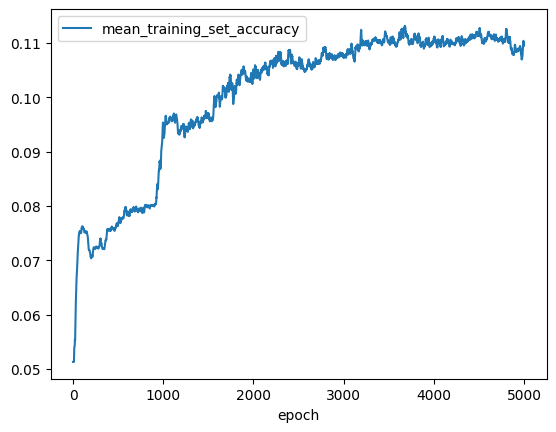

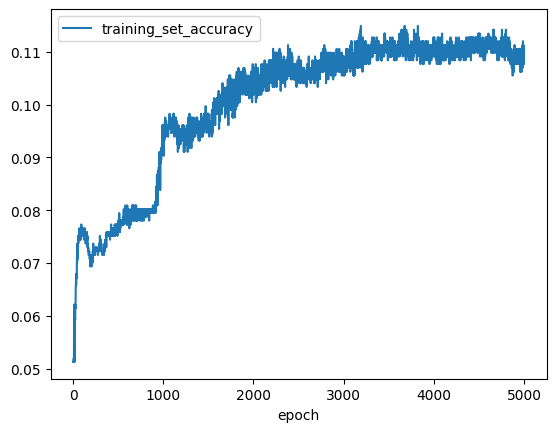

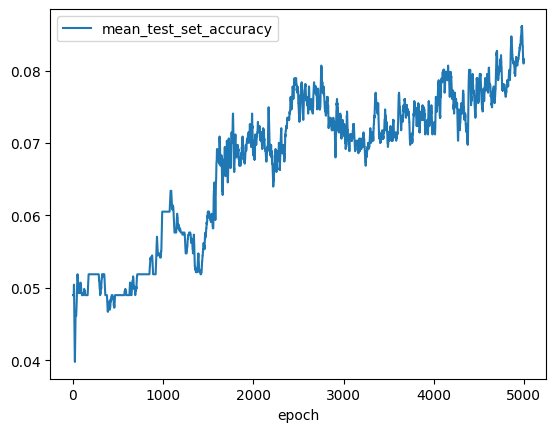

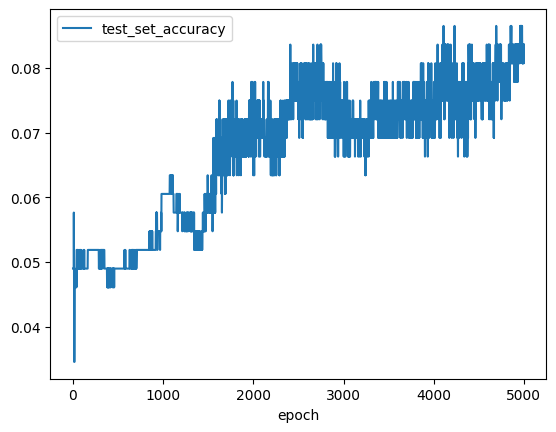

In [28]:
dual_layer_softmax_model =  tf.keras.models.Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(20, activation='softmax') # 5 possible classes (5 populations)
])

tester_dual_layer_softmax = ModelTester('Single Convolution layer', dual_layer_softmax_model)
tester_dual_layer_softmax.train(train_ds, test_ds, 5000)
test_set_accuracy_1024 = tester_dual_layer_softmax.get_final_test_set_accuracy()

In [26]:
print('128')
print(test_set_accuracy_128)
print('256')
print(test_set_accuracy_256)
print('512')
print(test_set_accuracy_512)
print('1024')
print(test_set_accuracy_1024)

128
0.18497109413146973
256
0.1637764871120453
512
0.12909440696239471
1024
0.11946050077676773
